# UC-7 Artifact Evaluate

Phase26.3 notebook with executed diagnostics outputs.

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_lift_chart,
    plot_love_plot,
    plot_nll_histogram,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_true_class_prob_histogram,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase26_2_uc07_artifact_evaluate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-7'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Workflow

,label,rmse,mae,r2,mape
0,artifact_evaluate,1.556196,1.091491,0.707193,NaN
1,artifact_recomputed,1.556196,1.091491,0.707193,0.816727


,x1,x2,y_true,fold_id,in_out_label,prediction,residual
0,0.082494,1.959839,-2.581521,0,evaluate,-3.009897,0.428376
1,-0.464418,1.963763,-4.661470,0,evaluate,-4.924339,0.262868
2,0.050515,2.094612,-3.015540,0,evaluate,-3.009897,-0.005643
3,0.686231,1.630200,-0.632432,0,evaluate,-0.758606,0.126173
4,-1.756791,2.008654,-8.359503,0,evaluate,-4.924339,-3.435164
5,1.684432,1.380346,3.172601,0,evaluate,-0.758606,3.931206
6,-0.457843,2.613416,-5.176478,0,evaluate,-4.924339,-0.252140
7,-0.596420,2.759602,-5.835669,0,evaluate,-4.924339,-0.911331
8,-1.046968,1.447801,-5.237494,0,evaluate,-4.924339,-0.313155
9,0.931792,2.213654,-0.788373,0,evaluate,-0.758606,-0.029768


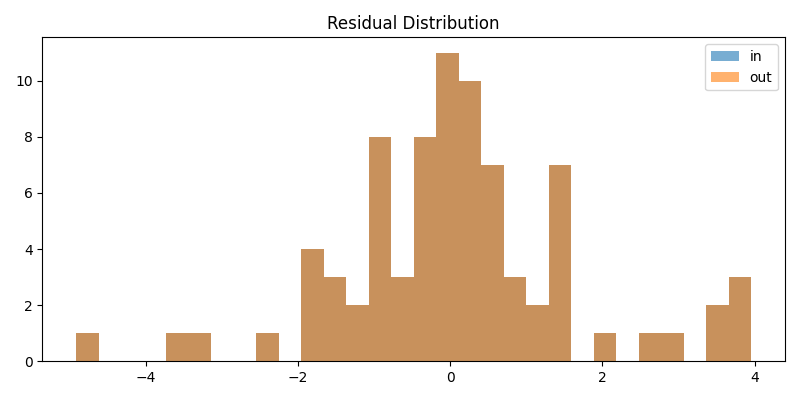

In [2]:
def _latest_artifact_path() -> Path:
    marker = ROOT / 'examples' / 'out' / 'phase26_2_uc01_regression_fit_evaluate' / 'latest_artifact_path.txt'
    if marker.exists():
        return Path(marker.read_text(encoding='utf-8').strip())
    candidates = sorted((ROOT / 'examples' / 'out' / 'phase26_2_uc01_regression_fit_evaluate' / 'artifacts').glob('*'))
    if not candidates:
        raise FileNotFoundError('No UC-1 artifact found.')
    return candidates[-1]

artifact_path = _latest_artifact_path()
artifact = Artifact.load(artifact_path)
eval_df = pd.read_csv(ROOT / 'examples' / 'out' / 'phase26_2_uc07_artifact_evaluate' / 'eval.csv')
eval_result = evaluate(artifact, eval_df)

x_eval = eval_df.drop(columns=['target'])
y_eval = eval_df['target'].to_numpy(dtype=float)
pred_eval = artifact.predict(x_eval)
metrics_df = pd.DataFrame(
    [
        {
            'label': 'artifact_evaluate',
            **eval_result.metrics,
        },
        regression_metrics(y_eval, pred_eval, label='artifact_recomputed'),
    ]
)
metrics_path = OUT_DIR / 'metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

residual = y_eval - np.asarray(pred_eval, dtype=float)
residual_path = diag_dir / 'eval_residual_hist.png'
plot_error_histogram(residual, residual, metrics_df.iloc[0].to_dict(), metrics_df.iloc[0].to_dict(), residual_path)

eval_table = build_regression_table(
    x_eval,
    y_eval,
    np.zeros(len(x_eval), dtype=int),
    np.asarray(pred_eval, dtype=float),
    ['evaluate'] * len(x_eval),
)
eval_table_path = OUT_DIR / 'eval_table.csv'
eval_table.to_csv(eval_table_path, index=False)

display(metrics_df)
display(eval_table.head(10))
display(Image(filename=str(residual_path)))

summary_outputs = [metrics_path, eval_table_path, residual_path]
artifact_path_for_summary = artifact_path


## Result Summary

In [3]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-7',
 'executed_at_utc': '2026-02-17T11:52:03.168057+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase26_2_uc01_regression_fit_evaluate/artifacts/1a23ab40a8b84f8b8a6195db1b27ff61',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase26_2_uc07_artifact_evaluate/metrics.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc07_artifact_evaluate/eval_table.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc07_artifact_evaluate/diagnostics/eval_residual_hist.png'],
 'metrics': [{'label': 'artifact_evaluate',
   'rmse': 1.556196,
   'mae': 1.091491,
   'r2': 0.707193,
   'mape': nan},
  {'label': 'artifact_recomputed',
   'rmse': 1.556196,
   'mae': 1.091491,
   'r2': 0.707193,
   'mape': 0.816727}]}